In [275]:

import numpy as np 

import pandas as pd


import os
from sklearn.ensemble import IsolationForest

train_dataset = pd.read_csv('/Users/ayberk/Downloads/train.csv')
test_dataset = pd.read_csv('/Users/ayberk/Downloads/test.csv')
plot_dataset = train_dataset

#train_dataset.set_index('DATETIME',inplace = True)
train_dataset.fillna(method= 'ffill',inplace = True)


#remove first 6 char of the string
train_dataset['SERVER'] = train_dataset['SERVER'].str[6:]
train_dataset['CPU'] = train_dataset['CPU'].str[4:]

start_date = '2020-05-15 00:00:00'
end_date = '2020-05-30 00:00:00'

train_dataset = train_dataset.loc[
    (train_dataset['DATETIME'] >= start_date) & (train_dataset['DATETIME'] <= end_date)
]






[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [276]:
train_dataset

,DATETIME,SERVER,CPU,CPULOAD
239112,2020-05-15 00:00:00+03:00,301,0,5.56
239113,2020-05-15 00:00:00+03:00,301,1,15.31
239114,2020-05-15 00:00:00+03:00,301,10,4.17
239115,2020-05-15 00:00:00+03:00,301,11,14.38
239116,2020-05-15 00:00:00+03:00,301,12,0.84
...,...,...,...,...
308083,2020-05-29 23:45:00+03:00,305,5,17.45
308084,2020-05-29 23:45:00+03:00,305,6,15.13
308085,2020-05-29 23:45:00+03:00,305,7,18.26
308086,2020-05-29 23:45:00+03:00,305,8,16.91


In [277]:
servers = train_dataset.groupby(train_dataset['SERVER'] == "301")

first_server = servers.get_group(True)
second_server = servers.get_group(False)



first_server = first_server.pivot(index = 'DATETIME', columns='CPU', values='CPULOAD')
second_server = second_server.pivot(index = 'DATETIME', columns = 'CPU', values = 'CPULOAD')

first_server_mean = first_server.mean(axis=1)
second_server_mean = second_server.mean(axis=1)


In [278]:
train = pd.DataFrame({'DATETIME':first_server.index, 'CPULOAD':first_server_mean.values, 'SERVER':301})

train['DATETIME'] = pd.to_datetime(train['DATETIME'])

In [279]:
def run_isolation_forest(model_data: pd.DataFrame, contamination=0.03, n_estimators=200, max_samples=0.7) -> pd.DataFrame:
    
    IF = (IsolationForest(random_state=0,
                          contamination=contamination,
                          n_estimators=n_estimators,
                          max_samples=max_samples)
         )
    
    IF.fit(model_data)
    
    output = pd.Series(IF.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)
    
    score = IF.decision_function(model_data)
    
    return output, score

In [280]:
outliers, score = run_isolation_forest(first_server)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [281]:
#outliers = np.nan_to_num(outliers, nan=0)

# Assign outliers and score to the train_dataset
train['outliers'] = outliers
train['score'] = score

train

,DATETIME,CPULOAD,SERVER,outliers,score
0,2020-05-15 00:00:00+03:00,5.892083,301,0,0.069812
1,2020-05-15 00:15:00+03:00,5.497500,301,0,0.095614
2,2020-05-15 00:30:00+03:00,5.030833,301,0,0.095318
3,2020-05-15 00:45:00+03:00,4.744167,301,0,0.115018
4,2020-05-15 01:00:00+03:00,4.488750,301,0,0.096196
...,...,...,...,...,...
1433,2020-05-29 22:45:00+03:00,7.652500,301,0,0.133634
1434,2020-05-29 23:00:00+03:00,7.094583,301,0,0.110396
1435,2020-05-29 23:15:00+03:00,6.924167,301,0,0.113608
1436,2020-05-29 23:30:00+03:00,6.390833,301,0,0.123883


In [282]:
def outliers(thresh):
    print(f'Number of Outliers below Anomaly Score Threshold {thresh}:')
    print(len(train.query(f"outliers == 1 & score <= {thresh}")))

In [283]:
train.head()

,DATETIME,CPULOAD,SERVER,outliers,score
0,2020-05-15 00:00:00+03:00,5.892083,301,0,0.069812
1,2020-05-15 00:15:00+03:00,5.497500,301,0,0.095614
2,2020-05-15 00:30:00+03:00,5.030833,301,0,0.095318
3,2020-05-15 00:45:00+03:00,4.744167,301,0,0.115018
4,2020-05-15 01:00:00+03:00,4.488750,301,0,0.096196


In [284]:
# Print outliers and scores
count = 0
for i in range(len(train)):
    if train.iloc[i]['outliers'] == 1 and train.iloc[i]['score'] <= -0.005:
        count +=1
print(count)

#Get anomalies_df
anomalies_df = train.query("outliers == 1 & score <= -0.005")
anomalies_df

42


,DATETIME,CPULOAD,SERVER,outliers,score
47,2020-05-15 11:45:00+03:00,15.132083,301,1,-0.005866
76,2020-05-15 19:00:00+03:00,15.406667,301,1,-0.037335
163,2020-05-16 16:45:00+03:00,13.615000,301,1,-0.028664
362,2020-05-18 18:30:00+03:00,13.086667,301,1,-0.014511
396,2020-05-19 03:00:00+03:00,7.258333,301,1,-0.053013
449,2020-05-19 16:15:00+03:00,14.849167,301,1,-0.050601
532,2020-05-20 13:00:00+03:00,16.823333,301,1,-0.043354
536,2020-05-20 14:00:00+03:00,15.953750,301,1,-0.058169
561,2020-05-20 20:15:00+03:00,12.535833,301,1,-0.054494
619,2020-05-21 10:45:00+03:00,14.041250,301,1,-0.011334


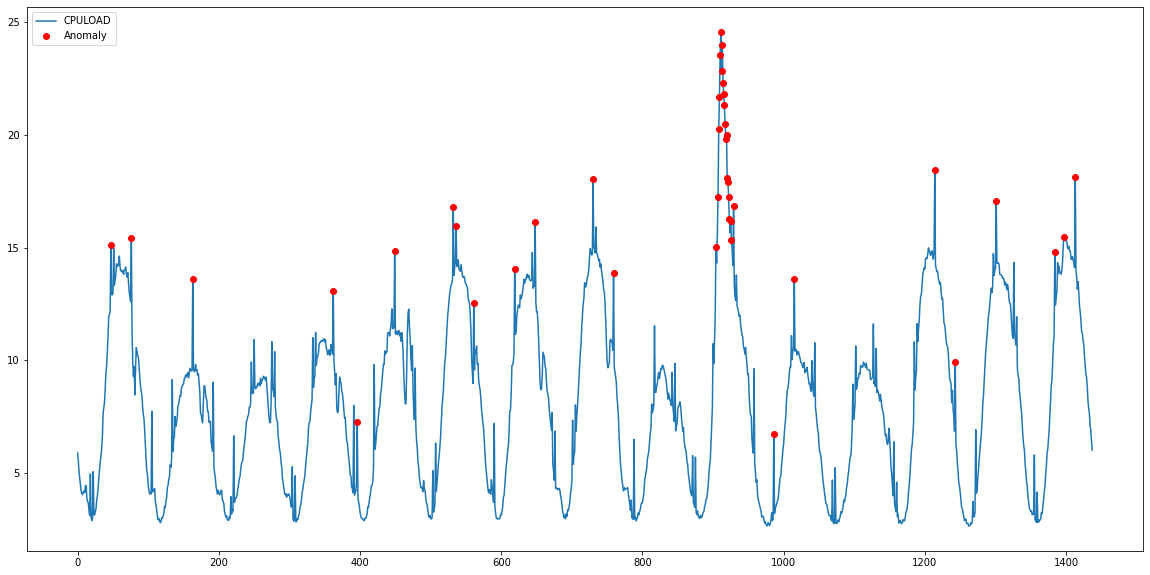

In [285]:
#draw a plot of train_dataset and anomalies_df
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(train['CPULOAD'], label='CPULOAD')
plt.plot(anomalies_df['CPULOAD'], 'ro', label='Anomaly')
plt.legend(loc='upper left')
plt.show()



In [286]:
train_second_server = pd.DataFrame({'DATETIME':second_server.index, 'CPULOAD':second_server_mean.values, 'SERVER':305})

train_second_server['DATETIME'] = pd.to_datetime(train_second_server['DATETIME'])


outliers, score = run_isolation_forest(second_server)


#outliers = np.nan_to_num(outliers, nan=0)


train_second_server['outliers'] = outliers
train_second_server['score'] = score

train_second_server
count = 0
for i in range(len(train_second_server)):
    if train_second_server.iloc[i]['outliers'] == 1 and train_second_server.iloc[i]['score'] <= -0.005:
        count +=1
print(count)


anomalies_df_second = train_second_server.query("outliers == 1 & score <= -0.005")
anomalies_df_second


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


41


,DATETIME,CPULOAD,SERVER,outliers,score
63,2020-05-15 15:45:00+03:00,31.427500,305,1,-0.049903
202,2020-05-17 03:00:00+03:00,12.401250,305,1,-0.005969
208,2020-05-17 04:30:00+03:00,3.951667,305,1,-0.005188
317,2020-05-18 08:00:00+03:00,9.182500,305,1,-0.022824
487,2020-05-20 02:30:00+03:00,9.776250,305,1,-0.021357
628,2020-05-21 13:45:00+03:00,29.121250,305,1,-0.046202
643,2020-05-21 17:30:00+03:00,26.637083,305,1,-0.008295
681,2020-05-22 03:00:00+03:00,10.407500,305,1,-0.010416
736,2020-05-22 16:45:00+03:00,31.470833,305,1,-0.030533
903,2020-05-24 10:45:00+03:00,33.679167,305,1,-0.053989


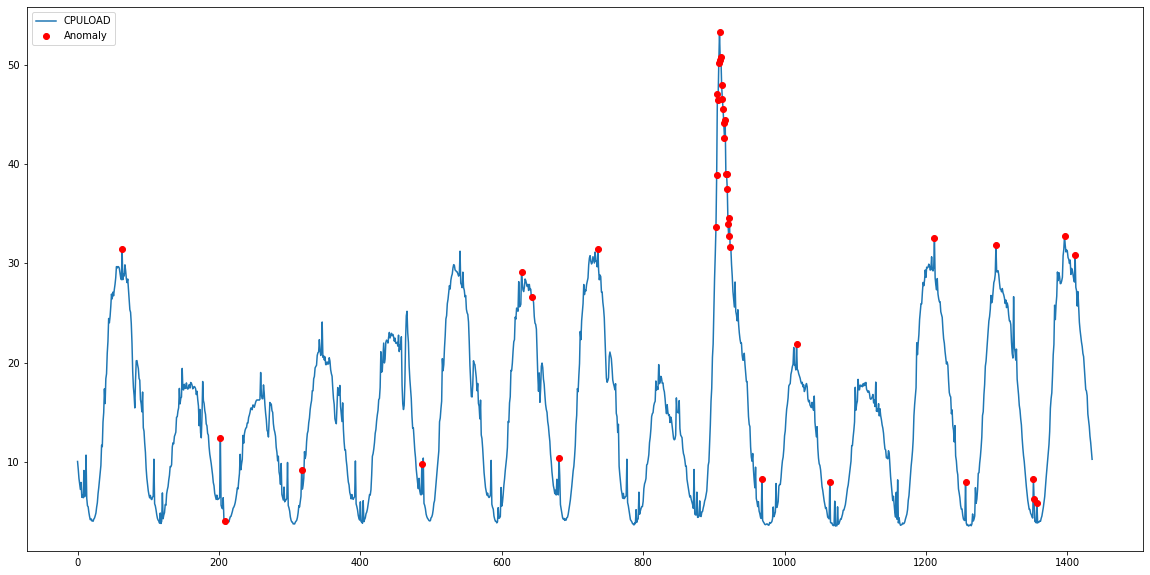

In [287]:


import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(train_second_server['CPULOAD'], label='CPULOAD')
plt.plot(anomalies_df_second['CPULOAD'], 'ro', label='Anomaly')
plt.legend(loc='upper left')
plt.show()


